# Machine Learning for Signal Processing
### (ENGR-E 511)
### Homework 6

## Problem 1:  Stereo Matching

### Initializing the required libraries

In [1]:
# Importing all Required Libraries
import os
import numpy as np
import librosa as lb
import pandas as pd
import scipy
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import Audio
from PIL import Image
import soundfile as sf
import math

In [2]:
#Change Dir
os.chdir('E:/JupiterNotebook/Assignment6data')

In [3]:
#Import Data
Xl_data = np.array(Image.open('im0.ppm'))
Xr_data = np.array(Image.open('im8.ppm'))

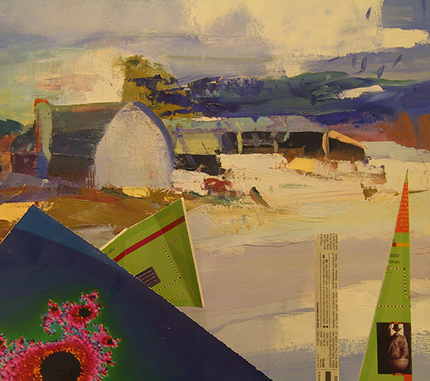

In [4]:
#Check Images
Image.open('im0.ppm')

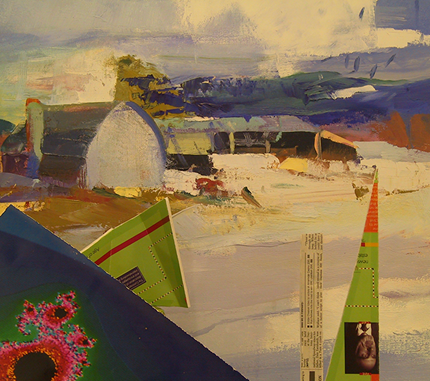

In [5]:
#Check Images
Image.open('im8.ppm')

In [6]:
#Print Shape
print(Xl_data.shape)
print(Xr_data.shape)

(381, 430, 3)
(381, 430, 3)


In [7]:
def sim_pixel(i,j):
    near = 0
    t = 1000000
    for k in range(40):
        d = sum(np.abs(Xr_data[i,j] - Xl_data[i,j+k]))
        if d < t:
            t = d
            near = k
    return near

In [8]:
d_map = np.zeros([Xl_data.shape[0], Xl_data.shape[1] - 40])

for i in range(d_map.shape[0]):
    for j in range(d_map.shape[1]):
        d_map[i,j] = sim_pixel(i,j)

d_vec = d_map.reshape(-1,1)

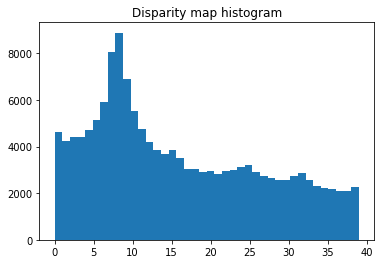

In [9]:
#Print Disparity map histogram
plt.title('Disparity map histogram')
plt.hist(d_vec, bins = 40)
plt.show()

In [10]:
def pdf_dist_N(mu, sigma, x):
    return (1/np.sqrt((2*np.pi*(sigma**2)))) * (np.exp(-(((x-mu)**2)/(2*(sigma**2)))))

In [11]:
def GMM(data, num_g):

    P_Clust = np.array([1/num_g]*num_g)
    np.random.seed(50)
    
    clust_means = np.random.uniform(10, 50, num_g)
    clust_sd = np.random.uniform(1, 5, num_g)

    probX_g_cluster = np.zeros((np.size(data), num_g))
    U_Cluster = np.zeros((np.size(data), num_g))

    for iter in range(0,500):
        for i in range(num_g):

            probX_g_cluster[:,i] = pdf_dist_N(clust_means[i], clust_sd[i], data).reshape(1,-1)
            probX_g_cluster[probX_g_cluster==0] = 0.00005

        P_X = np.sum(P_Clust*probX_g_cluster, axis=1)
        U_Cluster = P_Clust*probX_g_cluster/P_X.reshape(-1,1)

        clust_means = np.sum(U_Cluster*data.reshape(-1,1), axis = 0)/np.sum(U_Cluster, axis = 0)
        P_Clust = np.mean(U_Cluster, axis=0)

        for i in range(num_g):
            clust_sd[i] = np.sqrt(np.sum(U_Cluster[:,i].reshape(-1,1)*((data - clust_means[i])*\
                      (data - clust_means[i])))/np.sum(U_Cluster[:,i]))

    memb_mat = np.argmax(U_Cluster, axis = 1)
    df = pd.DataFrame(data)
    df.columns = ['Disparity Data']
    df['Cluster'] = memb_mat

    return clust_means, clust_sd, df

In [12]:
ClusterMeans, ClusterSDs, data_frame = GMM(d_vec, 4)
cluster_map= np.array(data_frame['Cluster'])
depth_map = np.array(data_frame['Cluster'], dtype=float)

for i in range(4):
    depth_map[depth_map == i] = ClusterMeans[i]

depth_map = depth_map.reshape(d_map.shape)
cluster_map = cluster_map.reshape(d_map.shape)

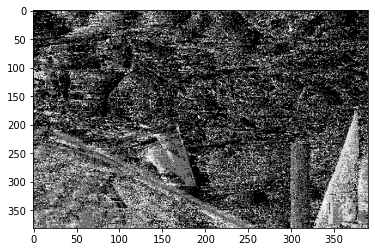

In [13]:
plt.imshow(depth_map,cmap="gray", aspect = 'auto')
plt.show()

In [14]:
s_clust_map = np.array(cluster_map)
prev_cluster_map = np.array(cluster_map)
s_depth_map = np.zeros(d_map.shape)

def sim(i, j, cluster):
    
    if i < 0 or j < 0 or i > prev_cluster_map.shape[0]-1 or j > prev_cluster_map.shape[1]-1\
        or prev_cluster_map[i,j] == cluster:
        return 1

    a = 5
    sigma = 0.5
    if prev_cluster_map[i,j] == cluster:
        a = 0

    return np.exp(-(a*a/(2*sigma*sigma)))

In [15]:
def prior(i,j,cluster):
    N = [-1,0,1]
    prior_p = 1

    for k in N:
        for l in N:
            prior_p *= sim(i+k,j+l, cluster)

    return prior_p

In [16]:
S = []
for iter in range(30):
    for i in range(d_map.shape[0]):
        for j in range(d_map.shape[1]):

            current_cluster = cluster_map[i,j]
            posterior = np.zeros(4)

            for k in range(4):
                posterior[k] = pdf_dist_N(ClusterMeans[k], ClusterSDs[k], depth_map[i,j]) * prior(i,j,k)

            posterior = posterior/np.sum(posterior)
            new_label = np.random.choice(np.arange(0, 4), p=posterior)
            s_depth_map[i,j] = ClusterMeans[new_label]
            s_clust_map[i,j] = new_label

    S.append(s_depth_map)
    prev_cluster_map = np.array(s_clust_map)

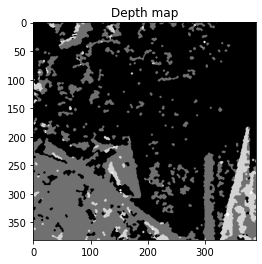

In [17]:
S = np.array(S)
s_final_map = scipy.stats.mode(S[-10:])[0][0]

plt.title('Depth map')
plt.imshow(s_final_map, cmap="gray")
plt.show()

Discussed above problem with Mohit

## Problem 2: Probabilistic Latent Semantic Indexing (PLSI) for Speech Denoising

In [18]:
#Loading Data
trs_data , trs_rate = lb.load('trs.wav', sr=None)
trn_data , trn_rate = lb.load('trn.wav', sr=None)

In [19]:
#Setting Random Seed
np.random.seed(143)

In [20]:
def STFT(data):
    return lb.stft(data,n_fft=1024,hop_length=512)

In [21]:
def conFloat(data):
    return data.astype(float)

In [22]:
#Check Audio
Audio('trs.wav', rate = 16000)

In [23]:
#Check Audio
Audio('trn.wav', rate = 16000)

In [24]:
#data to float
trs_data=conFloat(trs_data)
trn_data=conFloat(trn_data)

#STFT
S=STFT(trs_data)
N=STFT(trn_data)

In [25]:
print(S.shape)
print(N.shape)

(513, 893)
(513, 893)


In [26]:
# INIT KS value between 20-40
ks=25

#initializing Random Matrices
B_trs=np.random.uniform(0, 1, (S.shape[0],ks))
T_trs=np.random.uniform(0, 1, (ks,S.shape[1]))

In [27]:
# Taking real and abs part
s_real=np.real(S)
s_magnitude=np.absolute(s_real)

In [28]:
#E and M steps
s=0
while s<1000: 
    B_T=np.dot(B_trs,T_trs)
    S_T=s_magnitude/B_T
    RSP=np.dot(S_T,T_trs.T)
    B_trs= np.multiply(B_trs ,RSP)
    
    
    B_trs=B_trs+0.000001
    
    B_T=np.dot(B_trs,T_trs)
    S_T=s_magnitude/B_T    
    RSP=np.dot(B_trs.T, S_T)
    T_trs=np.multiply(T_trs,RSP)
    
    
    T_trs=T_trs+0.000001
    
    one=np.ones([S.shape[0], S.shape[0]])
    shr=np.dot(one,B_trs)
    B_trs=B_trs/shr
    
    one=np.ones([ks, ks])
    shr=np.dot(one,T_trs)
    T_trs=T_trs/shr
      
    s+=1

In [29]:
print(B_trs.shape)
print(T_trs.shape)

(513, 25)
(25, 893)


In [30]:
#initializing Random Matrices
B_trn=np.random.uniform(0, 1, (N.shape[0],ks))
T_trn=np.random.uniform(0, 1, (ks,N.shape[1]))

In [31]:
#Taking real and abs part
N_real=np.real(N)
n_magnitude=np.absolute(N_real)

In [32]:
#E and M Steps
s=0
while s<1000:
    B_T=np.dot(B_trn,T_trn)
    N_T=n_magnitude/B_T
    RSP=np.dot(N_T,T_trn.T)
    B_trn= np.multiply(B_trn ,RSP)
    B_trn=B_trn+0.000001
    
    B_T=np.dot(B_trn,T_trn)
    N_T=n_magnitude/B_T
    RSP=np.dot(B_trn.T, N_T)
    T_trn =np.multiply(T_trn,RSP)
    T_trn=T_trn+0.000001
    
    one=np.ones([N.shape[0], N.shape[0]])
    shr=np.dot(one,B_trn)
    B_trn=B_trn/shr
    
    one=np.ones([ks, ks])
    shr=np.dot(one,T_trn)
    T_trn=T_trn/shr
    
    s+=1

In [33]:
print(B_trn.shape)
print(T_trn.shape)

(513, 25)
(25, 893)


In [34]:
#Importing tex file
tex_data , tex_rate = lb.load('tex.wav', sr=None)

#Playing audio
Audio('tex.wav', rate = 16000)

In [35]:
#Converting data to float
tex_data=conFloat(tex_data)

#Applying STFT
tex_matrix=STFT(tex_data)

In [36]:
#Taking real and abs part
X_real=np.real(tex_matrix)
x_magnitude=np.absolute(X_real)

#Combining Matrix
B_combi=np.hstack((B_trs,B_trn))
B_combi.shape

T_X=np.random.uniform(0,1,(B_combi.shape[1],tex_matrix.shape[1]))

In [37]:
# E and M steps to converge
s=0
while s<1000:
   
    B_T=np.dot(B_combi,T_X)
    x_by_btheta=x_magnitude/B_T
    RSP=np.dot(B_combi.T, x_by_btheta)
    T_X =np.multiply(T_X,RSP)
    

    one=np.ones([2*ks, 2*ks])
    shr=np.dot(one,T_X)
    T_X=T_X/shr
    
    s+=1

In [38]:
T_X_ks=T_X[0:ks,:]
T_X_ks.shape

print(T_X.shape)
print(T_X_ks.shape)

(50, 161)
(25, 161)


In [39]:
#probability matrix
prob_mat=np.dot(B_trs , T_X_ks)
prob_mat.shape

(513, 161)

In [40]:
num=prob_mat
denom=np.dot(B_combi,T_X)

LSP=num/denom

s_bar_test=np.multiply(LSP,tex_matrix)

In [41]:
#Applying ISTFT
s_recovered=lb.istft(s_bar_test,n_fft=1024,hop_length=512)
s_recovered

array([-0.00374602, -0.00488969, -0.00539885, ..., -0.00029213,
       -0.00033332, -0.00034178])

In [42]:
Audio(s_recovered, rate=16000)

In [43]:
#Importing tes 
tes_data , tes_rate = lb.load('tes.wav', sr=None)
#SNR
og_data=tes_data
numerator_snr=sum(np.power(og_data,2))
diff=og_data-s_recovered
denom_snr=sum(np.power(diff,2))

SNR=10*math.log10(numerator_snr/denom_snr)
print(SNR)

8.909217174880867


## Problem 3: PLSI for Analyzing Twitter Stream

In [44]:
#Loading Data
twitter_data = scipy.io.loadmat('twitter.mat')

In [45]:
#Cheking Data
print(twitter_data .keys())

dict_keys(['__header__', '__version__', '__globals__', 'Xte', 'Xtr', 'YteMat', 'YtrMat'])


In [46]:
#Initialising Data
Xtr = twitter_data ['Xtr']
Xte = twitter_data ['Xte']
YtrMat = twitter_data ['YtrMat']
YteMat = twitter_data ['YteMat']

In [47]:
# Check shape
print(Xtr.shape)
print(Xte.shape)
print(YtrMat.shape)
print(YteMat.shape)

(891, 773)
(891, 193)
(3, 773)
(3, 193)


In [48]:
plsi_topics = np.random.randn(891, 50)
plsi_weights = np.random.randn(50, 773)

In [49]:
for i in range(500):

    den = np.dot(plsi_topics,plsi_weights)
    den[den == 0] = 0.0001

    plsi_topics = plsi_topics * np.dot((Xtr/den), plsi_weights.T)
    plsi_topics = plsi_topics / np.dot(np.ones([plsi_topics.shape[0], plsi_topics.shape[0]]), plsi_topics)

    den = np.dot(plsi_topics,plsi_weights)
    den[den == 0] = 0.0001

    plsi_weights = plsi_weights * np.dot(plsi_topics.T, (Xtr/den))
    plsi_weights = plsi_weights / np.dot(np.ones([plsi_weights.shape[0], plsi_weights.shape[0]]), plsi_weights)

In [50]:
plsi_weights2 = np.random.rand(50,193)

for i in range(500):

    den = np.dot(plsi_topics, plsi_weights2)
    den[den == 0] = 0.0001

    plsi_weights2 = plsi_weights2 * np.dot(plsi_topics.T, (Xte/den))
    plsi_weights2 = plsi_weights2 / np.dot(np.ones([plsi_weights2.shape[0], plsi_weights2.shape[0]]), plsi_weights2)

In [51]:
lern_rate = 0.005

W = np.random.uniform(0, 5, (3, plsi_weights.shape[0]))
b = np.random.uniform(0, 5, (3,1))
err = []

for i in range(1000):

    Y_Dash = np.exp(np.dot(W, plsi_weights) + b)
    Y_Dash = Y_Dash / np.sum(Y_Dash, axis=0).reshape(1,-1)
    
    error = -np.sum(YtrMat * np.log(Y_Dash))

    delta_w = np.dot((Y_Dash - YtrMat), plsi_weights.T)
    delta_b = np.dot((Y_Dash - YtrMat), np.ones([YtrMat.shape[1],1]))
    
    W = W - (lern_rate * delta_w)
    b = b - (lern_rate * delta_b)

    err.append(error)


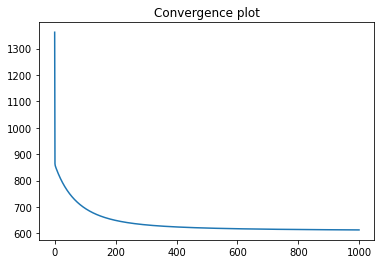

In [52]:
#Plotting Convergence plot
plt.title('Convergence plot')
plt.plot(err)
plt.show()

In [53]:
Z = np.dot(W, plsi_weights2) + b
Y_hat_test = np.exp(Z)

Y_hat_test = Y_hat_test / np.sum(Y_hat_test, axis=0).reshape(1,-1)

train_accuracy = np.sum(np.argmax(Y_Dash, axis=0) == np.argmax(YtrMat, axis=0)) / YtrMat.shape[1]
test_accuracy = np.sum(np.argmax(Y_hat_test, axis=0) == np.argmax(YteMat, axis=0)) / YteMat.shape[1]

In [54]:
print('Training accuacy: ' + str(np.round(train_accuracy, 4)))
print('Testing accuacy: ' + str(np.round(test_accuracy, 4)))

Training accuacy: 0.608
Testing accuacy: 0.5389
